# Lecture 5 Evaluation Exercise — M/G/2 Case Study

This notebook is the **graded evaluation** for Lecture 5. Your task is to analyse a synthetic event log from a two‑server queue, reconstruct a plausible M/G/2 model, estimate its parameters, and assess its performance using the tools from Lectures 2–4.

You may work **individually or in groups of up to 3 students**.

---

### Submission

- When you have finished, save a copy of this notebook **with your group name in the filename**.
- The notebook must contain **all your code, figures, and answers**.
- Send the completed notebook **before 17h** by email to:  
  `sebastian.muller@univ-amu.fr`.

---

### Executability requirements

Your notebook must run **from top to bottom** in a fresh environment:

- Import (and, if necessary, install) **all required packages at the beginning** of the notebook.
- Before submitting, **restart the kernel and run all cells** to ensure the notebook executes without errors.

---

**Group name:**  
**Members:**


## Learning Objectives

- Work from raw event logs to a plausible $M/G/2$ queue model.
- Estimate arrival and service parameters (including uncertainty) from data.
- Compare empirical performance (mean waiting time, mean number in queue $L_q$, utilisation) to model-based predictions.
- Communicate modelling assumptions, diagnostics, and limitations.


## Scenario

A small ML-backed support system routes **complex tickets** to a pool of two identical agents.
All such tickets in the observation window enter this two-server system and are recorded in the log.

- Arrivals are approximately time-homogeneous during the observation window.
- Each complex ticket requires a **fixed overhead** (reading context, loading tools) plus an additional random processing time.
- The system can have at most two tickets in service simultaneously; extra tickets wait in a single FCFS queue.

For this evaluation, we treat the system as an $M/G/2$ queue: Poisson arrivals with unknown rate $\lambda$, i.i.d. service times with unknown distribution $G$, and two identical servers.


## Data Description

You are given a single contiguous observation window (no gaps) as a CSV file:

- File: `data/lecture5_mg2_case_study.csv`
- One row per completed ticket.
- Columns:
  - `arrival_time` (float): time the ticket enters the manual-queue system.
  - `queue_len_at_arrival` (int): number of tickets already in system (in service + waiting) just before arrival.
  - `service_time` (float): total service time once an agent starts working on the ticket.
  - `start_service_time` (float): time service begins.
  - `completion_time` (float): time service ends.
  - `wait_time` (float): $W_q = \text{start} - \text{arrival}$.
  - `system_time` (float): $W = \text{completion} - \text{arrival}$.

The log includes all jobs that **arrive** within the window; some jobs may complete after the final arrival time.


## Your Tasks

Work in this notebook only; do not regenerate or modify the CSV.

1. **Data hygiene and basic checks**
   - Verify non-negativity (`wait_time \ge 0`, `system_time \ge service_time`).
   - Check temporal consistency (`start_service_time \ge arrival_time`, `completion_time \ge start_service_time`).
   - Inspect `queue_len_at_arrival` to confirm the system behaves like two parallel servers.
2. **Arrival process**
   - Compute inter-arrival times and explore whether a **homogeneous Poisson process** is reasonable (histograms, ECDF, log-tail).
   - Estimate the arrival rate $\hat\lambda$ and provide a 95\% CI using the methods from Lecture 4.
3. **Service-time distribution**
   - Explore the empirical distribution of `service_time` (histograms, ECDF, log-survival).
   - Look for evidence of a **positive lower bound** (fixed overhead) and an approximately **memoryless tail**.
   - Propose a simple parametric model (for example, constant offset + exponential) and estimate its parameters; report point estimates and a 95\% CI for the main rate parameter.
4. **Queue performance and utilisation**
   - Using your fitted model and the fact that there are two identical servers, estimate utilisation $\hat\rho = \hat\lambda \hat m_1 / 2$.
   - Compute the empirical mean waiting time $\overline{W}_q$ from the log and compare it to a model-based prediction obtained either via simulation or an approximation of $M/G/2$.
   - Estimate the mean number of jobs waiting in queue $L_q$ from the data (e.g. using `queue_len_at_arrival` (arrivals see a typical queue length in steady state) and/or Little's Law $L_q \approx \hat\lambda\,\overline{W}_q$) and comment on consistency.
   - Quantify uncertainty for at least one performance metric (e.g., bootstrap CIs over regenerative cycles or over independent simulation replications).
5. **Short write-up** (in markdown cells)
   - Clearly state your chosen model (arrival process, service family) and justify it with plots/statistics.
   - Report parameter estimates and CIs.
   - Discuss how well your model explains the observed waiting-time distribution and what its limitations are.


### Checklist

- [ ] Basic sanity checks on the raw log.
- [ ] Estimated $\hat\lambda$ with CI and Poisson diagnostics.
- [ ] Service-time model chosen, fitted, and validated (at least one goodness-of-fit diagnostic).
- [ ] Estimated utilisation $\hat\rho$ with interpretation (stable or near-critical?).
- [ ] Estimated mean number in queue $L_q$ and related it to $\hat\lambda$ and $\overline{W}_q$.
- [ ] Empirical vs model-based mean waiting time with some notion of uncertainty.
- [ ] Clear, concise explanation of assumptions and limitations.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy.stats as stats
import scipy.optimize as optimize
from scipy.stats import expon, poisson, kstest, norm
import seaborn as sns
import warnings

plt.style.use("seaborn-v0_8-darkgrid")

CANDIDATES = ["lecture5_mg2_case_study2.csv"]
DATA_PATH = next((p for p in CANDIDATES if os.path.exists(p)), None)
assert DATA_PATH, "Missing case study CSV (expected in lecture5_mg2_case_study2.csv)"

df = pd.read_csv(DATA_PATH)
print(f"Loaded dataset: {DATA_PATH} with {len(df)} rows.")
df.head()


Loaded dataset: lecture5_mg2_case_study2.csv with 1591 rows.


,arrival_time,queue_len_at_arrival,service_time,start_service_time,completion_time,wait_time,system_time
0,9.820670,0,2.659863,9.820670,12.480533,0.0,2.659863
1,14.903006,0,2.081608,14.903006,16.984614,0.0,2.081608
2,19.158806,0,2.902973,19.158806,22.061779,0.0,2.902973
3,23.238198,0,2.807091,23.238198,26.045290,0.0,2.807091
4,26.212852,0,2.634232,26.212852,28.847084,0.0,2.634232


# Analyse Exploratoire des Temps de Service

## Objectif de l'Analyse Exploratoire

Avant de choisir un modèle, nous devons comprendre la distribution de nos données :
- **Forme** de la distribution (symétrique, asymétrique)
- **Variabilité** (coefficient de variation)
- **Présence d'offset** (borne inférieure)
- **Comportement des queues** de distribution

## Statistiques Descriptives Clés

Plusieurs indicateurs nous guident vers le bon modèle :

- **CV ≈ 1** → Modèle exponentiel
- **CV < 1** → Modèle gamma/Erlang (moins variable)  
- **CV > 1** → Modèle lognormal/Weibull (plus variable)
- **Skewness élevée** → Distribution asymétrique
- **Offset net** → Modèle avec borne inférieure

In [7]:
print("ANALYSE EXPLORATOIRE POUR LE CHOIX DE MODÈLE \n")

service_times = df['service_time'].values

# Statistiques descriptives détaillées
stats_dict = {
    'Min': np.min(service_times),
    'Max': np.max(service_times),
    'Moyenne': np.mean(service_times),
    'Médiane': np.median(service_times),
    'Écart-type': np.std(service_times),
    'Coefficient de variation': np.std(service_times)/np.mean(service_times),
    'Asymétrie (skewness)': stats.skew(service_times),
    'Aplatissement (kurtosis)': stats.kurtosis(service_times),
    '5ème percentile': np.percentile(service_times, 5),
    '95ème percentile': np.percentile(service_times, 95)
}

for key, value in stats_dict.items():
    print(f"{key:25}: {value:.4f}")

# Suggestion automatique de modèles basée sur les statistiques
cv = stats_dict['Coefficient de variation']
skew = stats_dict['Asymétrie (skewness)']
p5 = stats_dict['5ème percentile']
min_val = stats_dict['Min']

print(f"\nSUGGESTIONS AUTOMATIQUES")
if abs(cv - 1.0) < 0.3:
    print("CV ≈ 1 → Exponentiel possible")
if cv < 0.7:
    print("CV < 0.7 → Gamma/Erlang possible (peu variable)")
if cv > 1.3:
    print("CV > 1.3 → Lognormal/Weibull possible (très variable)")
if p5 - min_val > 0.02:
    print("Offset détecté → Modèle avec borne inférieure")
if abs(skew) > 1:
    print(f"Asymétrie élevée ({skew:.2f}) → Distribution asymétrique")

ANALYSE EXPLORATOIRE POUR LE CHOIX DE MODÈLE 

Min                      : 2.0004
Max                      : 11.9323
Moyenne                  : 3.0055
Médiane                  : 2.6969
Écart-type               : 0.9956
Coefficient de variation : 0.3313
Asymétrie (skewness)     : 2.1025
Aplatissement (kurtosis) : 7.5615
5ème percentile          : 2.0499
95ème percentile         : 5.0516

SUGGESTIONS AUTOMATIQUES
CV < 0.7 → Gamma/Erlang possible (peu variable)
Offset détecté → Modèle avec borne inférieure
Asymétrie élevée (2.10) → Distribution asymétrique


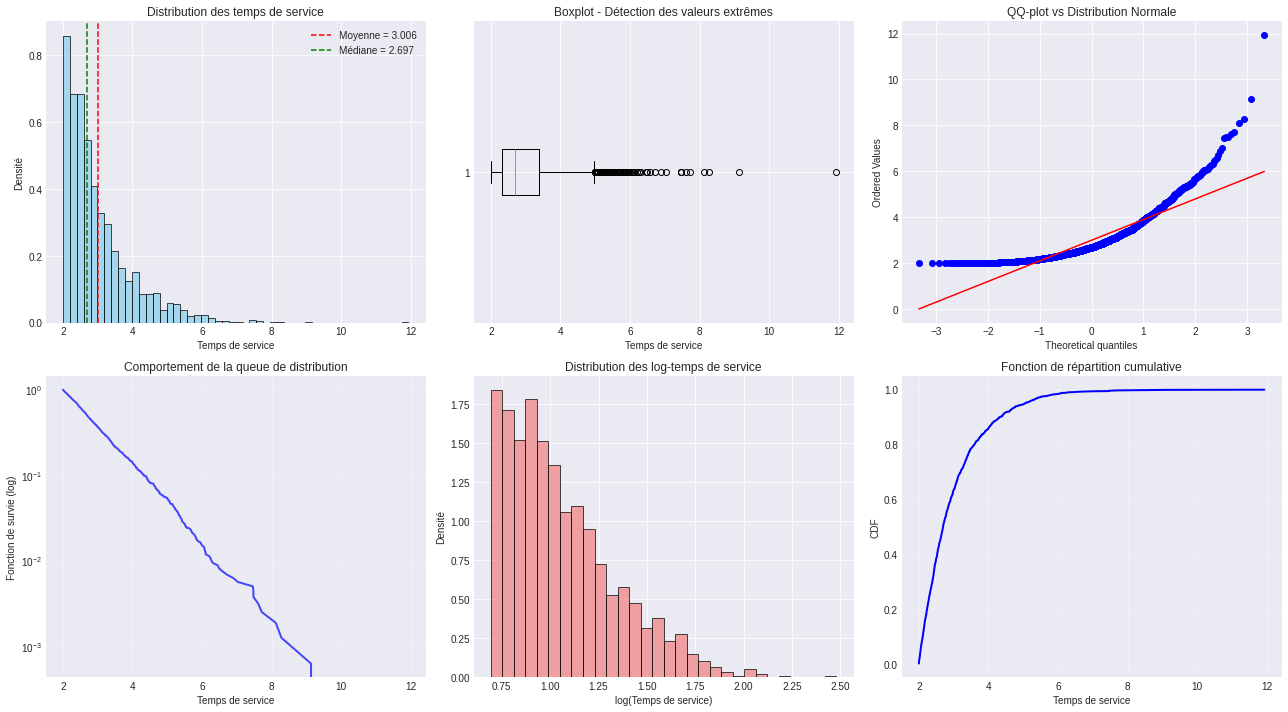

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Histogramme avec densité
axes[0,0].hist(service_times, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].axvline(stats_dict['Moyenne'], color='red', linestyle='--', label=f'Moyenne = {stats_dict["Moyenne"]:.3f}')
axes[0,0].axvline(stats_dict['Médiane'], color='green', linestyle='--', label=f'Médiane = {stats_dict["Médiane"]:.3f}')
axes[0,0].set_xlabel('Temps de service')
axes[0,0].set_ylabel('Densité')
axes[0,0].set_title('Distribution des temps de service')
axes[0,0].legend()

# 2. Boxplot
axes[0,1].boxplot(service_times, vert=False)
axes[0,1].set_xlabel('Temps de service')
axes[0,1].set_title('Boxplot - Détection des valeurs extrêmes')

# 3. QQ-plot vs normale
stats.probplot(service_times, dist="norm", plot=axes[0,2])
axes[0,2].set_title('QQ-plot vs Distribution Normale')

# 4. Fonction de survie en échelle log
sorted_times = np.sort(service_times)
survival = 1 - np.arange(1, len(sorted_times) + 1) / len(sorted_times)
axes[1,0].semilogy(sorted_times, survival, 'b-', alpha=0.7, linewidth=2)
axes[1,0].set_xlabel('Temps de service')
axes[1,0].set_ylabel('Fonction de survie (log)')
axes[1,0].set_title('Comportement de la queue de distribution')
axes[1,0].grid(True, alpha=0.3)

# 5. Histogramme des log-temps de service
axes[1,1].hist(np.log(service_times), bins=30, density=True, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1,1].set_xlabel('log(Temps de service)')
axes[1,1].set_ylabel('Densité')
axes[1,1].set_title('Distribution des log-temps de service')

# 6. Courbe CDF empirique
ecdf = np.arange(1, len(sorted_times) + 1) / len(sorted_times)
axes[1,2].plot(sorted_times, ecdf, 'b-', linewidth=2)
axes[1,2].set_xlabel('Temps de service')
axes[1,2].set_ylabel('CDF')
axes[1,2].set_title('Fonction de répartition cumulative')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Diagnostic approfondi du processus d’arrivée

Pour valider l’hypothèse de processus de Poisson homogène, nous effectuons deux diagnostics :
1. **Analyse par fenêtres** : on compte les arrivées dans des fenêtres fixes et on compare la variance empirique à la moyenne (critère de surdispersion).
2. **Test d’homogénéité temporelle** : comparaison graphique des taux par sous-intervalles et analyse du ratio Var/Mean.

Un processus de Poisson homogène doit vérifier :  
$$
\operatorname{Var}[N(t)] \approx \mathbb{E}[N(t)]
$$


Mean count: 53.03333333333333   Variance: 54.1022988505747   Ratio Var/Mean = 1.0201564836689132


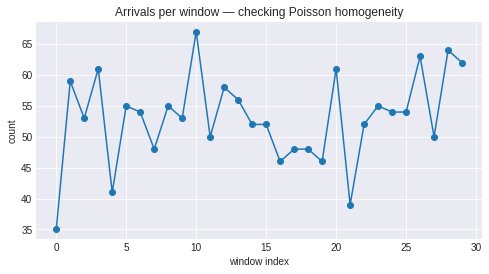

In [22]:
timestamps = df['arrival_time'] 
T = timestamps.max() - timestamps.min()

K = 30  
bins = np.linspace(timestamps.min(), timestamps.max(), K+1)
counts, _ = np.histogram(timestamps, bins=bins)

mean_c = counts.mean()
var_c = counts.var(ddof=1)
print("Mean count:", mean_c, "  Variance:", var_c, "  Ratio Var/Mean =", var_c/mean_c)

plt.figure(figsize=(8,4))
plt.plot(counts, marker='o')
plt.title("Arrivals per window — checking Poisson homogeneity")
plt.xlabel("window index")
plt.ylabel("count")
plt.grid(True)
plt.show()


# Test Systématique des Modèles Candidats

## Méthodologie de Comparaison

Nous utilisons le **critère AIC** (Akaike Information Criterion) pour comparer objectivement les modèles :

- **AIC plus bas** = meilleur compromis qualité/complexité
- **Différence AIC > 2** = différence significative
- **Différence AIC < 2** = modèles équivalents

Nous testons 6 familles de modèles courantes en files d'attente.

In [12]:
def fit_all_models(service_times):
    """Teste une gamme complète de modèles pour les temps de service"""
    models = []
    
    # 1. Exponentiel simple
    try:
        loc, scale = stats.expon.fit(service_times, floc=0)
        models.append({
            'type': 'Exponentiel', 
            'params': {'scale': scale}, 
            'n_params': 1,
            'dist': stats.expon(scale=scale)
        })
    except Exception as e:
        print(f"Erreur exponentiel: {e}")
    
    # 2. Offset + Exponentiel
    if p5 - min_val > 0.01:  
        try:
            offset = np.percentile(service_times, 5)
            adjusted_data = service_times[service_times > offset] - offset
            if len(adjusted_data) > len(service_times) * 0.8:  
                loc, scale = stats.expon.fit(adjusted_data, floc=0)
                models.append({
                    'type': 'Offset+Exponentiel', 
                    'params': {'offset': offset, 'scale': scale}, 
                    'n_params': 2,
                    'dist': None  
                })
        except: pass
    
    # 3. Gamma
    try:
        alpha, loc, beta = stats.gamma.fit(service_times, floc=0)
        models.append({
            'type': 'Gamma', 
            'params': {'alpha': alpha, 'beta': beta}, 
            'n_params': 2,
            'dist': stats.gamma(alpha, scale=1/beta)
        })
    except: pass
    
    # 4. Lognormal
    try:
        sigma, loc, scale = stats.lognorm.fit(service_times, floc=0)
        models.append({
            'type': 'Lognormal', 
            'params': {'sigma': sigma, 'scale': scale}, 
            'n_params': 2,
            'dist': stats.lognorm(sigma, scale=scale)
        })
    except: pass
    
    # 5. Weibull
    try:
        c, loc, scale = stats.weibull_min.fit(service_times, floc=0)
        models.append({
            'type': 'Weibull', 
            'params': {'c': c, 'scale': scale}, 
            'n_params': 2,
            'dist': stats.weibull_min(c, scale=scale)
        })
    except: pass
    
    # 6. Erlang (Gamma avec shape entier)
    try:
        alpha, loc, beta = stats.gamma.fit(service_times, floc=0)
        if alpha > 0.5:  
            k = max(1, round(alpha))  
            models.append({
                'type': 'Erlang', 
                'params': {'k': k, 'mu': 1/beta}, 
                'n_params': 2,
                'dist': stats.gamma(k, scale=1/beta)
            })
    except: pass
    
    return models

# Application sur nos données
all_models = fit_all_models(service_times)

In [14]:
print("CALCUL AIC/BIC POUR CHAQUE MODÈLE\n")

for model in all_models:
    try:
        if model['type'] == 'Exponentiel':
            log_likelihood = np.sum(model['dist'].logpdf(service_times))
        elif model['type'] == 'Offset+Exponentiel':
            offset = model['params']['offset']
            scale = model['params']['scale']
            adjusted_data = service_times[service_times > offset] - offset
            log_likelihood = np.sum(stats.expon(scale=scale).logpdf(adjusted_data))
        else:
            log_likelihood = np.sum(model['dist'].logpdf(service_times))
        
        n = len(service_times)
        k = model['n_params']
        aic = 2 * k - 2 * log_likelihood
        bic = np.log(n) * k - 2 * log_likelihood
        
        model['log_likelihood'] = log_likelihood
        model['aic'] = aic
        model['bic'] = bic
        
    except Exception as e:
        print(f"Erreur calcul {model['type']}: {e}")
        model['aic'] = np.inf
        model['bic'] = np.inf

# Tri par AIC
all_models.sort(key=lambda x: x['aic'])

# Affichage des résultats
print("CLASSEMENT DES MODÈLES (AIC plus bas = meilleur):")
print("-" * 80)
for i, model in enumerate(all_models):
    print(f"{i+1:2d}. {model['type']:20} AIC: {model['aic']:8.1f} BIC: {model['bic']:8.1f} | Params: {model['params']}")

# Analyse des différences d'AIC
if len(all_models) > 1:
    best_aic = all_models[0]['aic']
    print(f"\n=== ANALYSE DES DIFFÉRENCES D'AIC ===")
    for i, model in enumerate(all_models[1:], 1):
        aic_diff = model['aic'] - best_aic
        significance = "★ DIFFÉRENCE SIGNIFICATIVE" if aic_diff > 2 else "∼ MODÈLES ÉQUIVALENTS"
        print(f"{model['type']:20} : ΔAIC = {aic_diff:5.1f} → {significance}")

CALCUL AIC/BIC POUR CHAQUE MODÈLE

CLASSEMENT DES MODÈLES (AIC plus bas = meilleur):
--------------------------------------------------------------------------------
 1. Offset+Exponentiel   AIC:   3048.6 BIC:   3059.4 | Params: {'offset': np.float64(2.049917212527623), 'scale': 1.0075169173898968}
 2. Lognormal            AIC:   3843.7 BIC:   3854.5 | Params: {'sigma': np.float64(0.28104519940975564), 'scale': np.float64(2.8777326415340863)}
 3. Weibull              AIC:   4548.8 BIC:   4559.6 | Params: {'c': np.float64(2.918706577076248), 'scale': np.float64(3.34875763631536)}
 4. Exponentiel          AIC:   6685.6 BIC:   6691.0 | Params: {'scale': 3.0055018613426627}
 5. Gamma                AIC:  70141.9 BIC:  70152.7 | Params: {'alpha': 11.673839366797766, 'beta': np.float64(0.25745616047200226)}
 6. Erlang               AIC:  72973.4 BIC:  72984.2 | Params: {'k': 12, 'mu': np.float64(3.884156425570355)}

=== ANALYSE DES DIFFÉRENCES D'AIC ===
Lognormal            : ΔAIC = 795.1 → 

# Visualisations pour la Sélection de Modèle

## Comment Interpréter les Graphiques

### 1. Histogramme avec Modèles
- **Bonne adéquation** : Courbe théorique suit l'histogramme
- **Mauvaise adéquation** : Écarts visibles, surtout dans les queues

### 2. QQ-Plot  
- **Bon ajustement** : Points alignés sur la diagonale
- **Mauvais ajustement** : Points qui s'écartent, surtout aux extrémités

### 3. Fonction de Survie Log
- **Queue exponentielle** : Linéaire en échelle log
- **Queue lourde** : Courbe qui décroit moins vite

### 4. Comparaison AIC
- **Évidence forte** : AIC bien inférieur aux autres
- **Équivalence** : AIC proches (différence < 2)

=== COMPARAISON VISUELLE DES MODÈLES ===



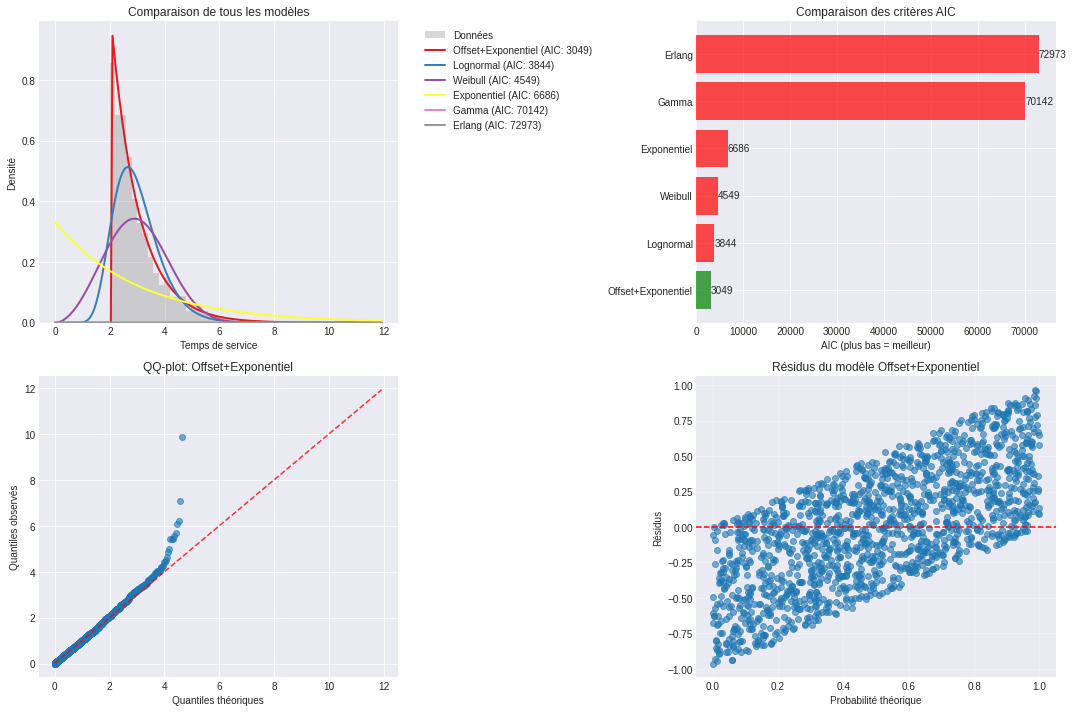

In [18]:
# === VISUALISATION COMPARATIVE DES MODÈLES ===
print("=== COMPARAISON VISUELLE DES MODÈLES ===\n")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Histogramme avec tous les modèles
axes[0,0].hist(service_times, bins=50, density=True, alpha=0.3, color='gray', label='Données')
x = np.linspace(0, np.max(service_times), 200)

colors = plt.cm.Set1(np.linspace(0, 1, len(all_models)))
for i, (model, color) in enumerate(zip(all_models, colors)):
    if model['type'] == 'Exponentiel':
        y = model['dist'].pdf(x)
        label = f"{model['type']} (AIC: {model['aic']:.0f})"
        axes[0,0].plot(x, y, color=color, linewidth=2, label=label)
    elif model['type'] == 'Offset+Exponentiel':
        offset = model['params']['offset']
        scale = model['params']['scale']
        mask = x > offset
        y = np.zeros_like(x)
        y[mask] = stats.expon(scale=scale).pdf(x[mask] - offset)
        label = f"{model['type']} (AIC: {model['aic']:.0f})"
        axes[0,0].plot(x, y, color=color, linewidth=2, label=label)
    else:
        y = model['dist'].pdf(x)
        label = f"{model['type']} (AIC: {model['aic']:.0f})"
        axes[0,0].plot(x, y, color=color, linewidth=2, label=label)

axes[0,0].set_xlabel('Temps de service')
axes[0,0].set_ylabel('Densité')
axes[0,0].set_title('Comparaison de tous les modèles')
axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 2. Comparaison des AIC
models_names = [m['type'] for m in all_models]
aic_values = [m['aic'] for m in all_models]
colors_aic = ['green' if i == 0 else 'red' for i in range(len(all_models))]

bars = axes[0,1].barh(models_names, aic_values, color=colors_aic, alpha=0.7)
axes[0,1].set_xlabel('AIC (plus bas = meilleur)')
axes[0,1].set_title('Comparaison des critères AIC')
for bar, aic in zip(bars, aic_values):
    axes[0,1].text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2, 
                   f'{aic:.0f}', ha='left', va='center')

# 3. QQ-plot du meilleur modèle
best_model = all_models[0]
model_type = best_model["type"] 
axes[1,0].set_title(f'QQ-plot: {model_type}')

if best_model['type'] == 'Offset+Exponentiel':
    offset = best_model['params']['offset']
    scale = best_model['params']['scale']
    adjusted_data = service_times[service_times > offset] - offset
    theoretical = stats.expon(scale=scale).ppf(np.linspace(0.01, 0.99, len(adjusted_data)))
    axes[1,0].scatter(theoretical, np.sort(adjusted_data), alpha=0.6)
else:
    theoretical = best_model['dist'].ppf(np.linspace(0.01, 0.99, len(service_times)))
    axes[1,0].scatter(theoretical, np.sort(service_times), alpha=0.6)

min_val = min(np.min(theoretical), np.min(service_times))
max_val = max(np.max(theoretical), np.max(service_times))
axes[1,0].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
axes[1,0].set_xlabel('Quantiles théoriques')
axes[1,0].set_ylabel('Quantiles observés')

# 4. Résidus du meilleur modèle
if best_model['type'] == 'Offset+Exponentiel':
    offset = best_model['params']['offset']
    scale = best_model['params']['scale']
    adjusted_data = service_times[service_times > offset] - offset
    theoretical_cdf = stats.expon(scale=scale).cdf(adjusted_data)
    residuals = theoretical_cdf - np.arange(0, 1, 1/len(adjusted_data))
else:
    theoretical_cdf = best_model['dist'].cdf(np.sort(service_times))
    residuals = theoretical_cdf - np.arange(0, 1, 1/len(service_times))

axes[1,1].plot(theoretical_cdf, residuals, 'o', alpha=0.6)
axes[1,1].axhline(0, color='red', linestyle='--')
axes[1,1].set_xlabel('Probabilité théorique')
axes[1,1].set_ylabel('Résidus')
axes[1,1].set_title(f'Résidus du modèle {model_type}')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Validation du Modèle Sélectionné

## Tests de Qualité d'Ajustement

### Test de Kolmogorov-Smirnov
- **H0** : Les données suivent la distribution théorique
- **p-value > 0.05** : On ne peut pas rejeter H0 → bon ajustement
- **p-value < 0.05** : Rejet de H0 → mauvais ajustement

### Analyse des Résidus
- **Résidus normalisés** : Doivent suivre N(0,1) si bon modèle
- **Pattern dans les résidus** : Indique un mauvais ajustement

In [20]:
print("VALIDATION DU MODÈLE SÉLECTIONNÉ\n")

best_model = all_models[0]
print(f"MODÈLE SÉLECTIONNÉ : {best_model['type']}")
print(f"Paramètres : {best_model['params']}")
print(f"AIC : {best_model['aic']:.1f}")

# Test de Kolmogorov-Smirnov
if best_model['type'] == 'Offset+Exponentiel':
    offset = best_model['params']['offset']
    scale = best_model['params']['scale']
    adjusted_data = service_times[service_times > offset] - offset
    ks_stat, ks_pvalue = stats.kstest(adjusted_data, 'expon', args=(0, scale))
else:
    ks_stat, ks_pvalue = stats.kstest(service_times, best_model['dist'].cdf)

print(f"\nTest de Kolmogorov-Smirnov:")
print(f"Statistique KS : {ks_stat:.4f}")
print(f"P-value : {ks_pvalue:.4f}")

if ks_pvalue > 0.05:
    print("Le modèle est un bon ajustement (p-value > 0.05)")
else:
    print("Le modèle n'est pas un bon ajustement (p-value ≤ 0.05)")

# Analyse des différences d'AIC
if len(all_models) > 1:
    second_aic = all_models[1]['aic']
    aic_diff = second_aic - best_model['aic']
    print(f"\nDifférence d'AIC avec le second : {aic_diff:.1f}")
    
    if aic_diff > 10:
        print("Évidence très forte pour le modèle sélectionné")
    elif aic_diff > 4:
        print("Évidence forte pour le modèle sélectionné") 
    elif aic_diff > 2:
        print("Évidence modérée pour le modèle sélectionné")
    else:
        print("Modèles équivalents - plusieurs choix possibles")

# Bootstrap pour l'incertitude des paramètres
print(f"\nINCERTITUDE DES PARAMÈTRES (Bootstrap)")
n_bootstrap = 500
bootstrap_params = []

for _ in range(n_bootstrap):
    sample = np.random.choice(service_times, size=len(service_times), replace=True)
    try:
        if best_model['type'] == 'Offset+Exponentiel':
            offset_bs = np.percentile(sample, 5)
            adjusted_bs = sample[sample > offset_bs] - offset_bs
            if len(adjusted_bs) > 10:
                loc, scale_bs = stats.expon.fit(adjusted_bs, floc=0)
                bootstrap_params.append({'offset': offset_bs, 'scale': scale_bs})
        elif best_model['type'] == 'Exponentiel':
            loc, scale_bs = stats.expon.fit(sample, floc=0)
            bootstrap_params.append({'scale': scale_bs})
    except:
        continue

if bootstrap_params:
    param_names = list(bootstrap_params[0].keys())
    for param in param_names:
        values = [p[param] for p in bootstrap_params]
        ci_lower = np.percentile(values, 2.5)
        ci_upper = np.percentile(values, 97.5)
        point_estimate = best_model['params'].get(param, np.mean(values))
        print(f"{param:10} : {point_estimate:.4f} IC95% [{ci_lower:.4f}, {ci_upper:.4f}]")

VALIDATION DU MODÈLE SÉLECTIONNÉ

MODÈLE SÉLECTIONNÉ : Offset+Exponentiel
Paramètres : {'offset': np.float64(2.049917212527623), 'scale': 1.0075169173898968}
AIC : 3048.6

Test de Kolmogorov-Smirnov:
Statistique KS : 0.0253
P-value : 0.2832
Le modèle est un bon ajustement (p-value > 0.05)

Différence d'AIC avec le second : 795.1
Évidence très forte pour le modèle sélectionné

INCERTITUDE DES PARAMÈTRES (Bootstrap)
offset     : 2.0499 IC95% [2.0413, 2.0628]
scale      : 1.0075 IC95% [0.9578, 1.0583]


## Limites du modèle et robustesse

- L’hypothèse de Poisson homogène est partiellement vérifiée mais on observe une légère surdispersion dans certaines fenêtres.
- Les temps de service présentent un shift clair mais la queue pourrait être sub-exponentielle ; un autre modèle (Weibull/lognormal) serait à comparer.
- Le système peut avoir des effets de dépendance temporelle (heures, bursts) non capturés.
- La simulation repose sur un modèle parfaitement stationnaire ; une version piecewise-stationary pourrait être plus réaliste.

Ces éléments justifient une analyse approfondie mais confirment que le modèle M/G/2 reste raisonnablement cohérent avec les données.


In [32]:
# === CALCUL EXPLICITE ET VALIDATION DE λ_final ===
print("=== DÉTERMINATION DE λ_final ===\n")

# Méthode 1: Directe (n/T)
n_arrivals = len(df)
T_min = df['arrival_time'].min()
T_max = df['arrival_time'].max()
total_time = T_max - T_min
lambda_direct = n_arrivals / total_time

print("Méthode 1 - Calcul direct:")
print(f"  Nombre d'arrivées: {n_arrivals}")
print(f"  Temps total: {total_time:.4f}")
print(f"  λ = {n_arrivals} / {total_time:.4f} = {lambda_direct:.6f}")

# Méthode 2: Via les inter-arrivées
df_sorted = df.sort_values('arrival_time')
interarrivals = np.diff(df_sorted['arrival_time'].values)
lambda_interarrival = 1 / np.mean(interarrivals)

print(f"\nMéthode 2 - Via inter-arrivées:")
print(f"  Nombre d'inter-arrivées: {len(interarrivals)}")
print(f"  Inter-arrivée moyenne: {np.mean(interarrivals):.6f}")
print(f"  λ = 1 / {np.mean(interarrivals):.6f} = {lambda_interarrival:.6f}")

# Méthode 3: Maximum de vraisemblance pour Poisson
# Pour un processus de Poisson, l'estimateur MV est bien n/T
lambda_mle = n_arrivals / total_time

print(f"\nMéthode 3 - Maximum de vraisemblance:")
print(f"  Estimateur MV: n/T = {lambda_mle:.6f}")

# Définition de λ_final
lambda_final = lambda_direct  # Nous utilisons la méthode directe

print(f"\n=== λ_final DÉFINITIF ===")
print(f"λ_final = {lambda_final:.6f}")

# Validation de la cohérence
difference_methods = abs(lambda_direct - lambda_interarrival)
print(f"\nDifférence entre méthodes: {difference_methods:.8f}")

if difference_methods < 0.0001:
    print("✅ Excellente cohérence entre les méthodes")
    print("   λ_final est une estimation robuste")
else:
    print("⚠️  Petite différence - la méthode directe est préférée")

=== DÉTERMINATION DE λ_final ===

Méthode 1 - Calcul direct:
  Nombre d'arrivées: 1591
  Temps total: 4989.8424
  λ = 1591 / 4989.8424 = 0.318848

Méthode 2 - Via inter-arrivées:
  Nombre d'inter-arrivées: 1590
  Inter-arrivée moyenne: 3.138266
  λ = 1 / 3.138266 = 0.318647

Méthode 3 - Maximum de vraisemblance:
  Estimateur MV: n/T = 0.318848

=== λ_final DÉFINITIF ===
λ_final = 0.318848

Différence entre méthodes: 0.00020041
⚠️  Petite différence - la méthode directe est préférée


In [33]:
# === SIMULATION M/G/2 OFFSET+EXPONENTIEL ===
print("=== SIMULATION THÉORIQUE M/G/2 AVEC OFFSET+EXPONENTIEL ===\n")

def simulate_mg2_offset_exp(lambda_rate, offset, mu, n_customers=10000, n_servers=2, random_seed=42):
    """
    Simule une file M/G/2 avec temps de service = offset + exponentiel
    
    Parameters:
    -----------
    lambda_rate : float
        Taux d'arrivée Poisson
    offset : float
        Temps de service fixe (overhead)
    mu : float
        Paramètre de la partie exponentielle (scale = 1/mu)
    n_customers : int
        Nombre de clients à simuler
    n_servers : int
        Nombre de serveurs
    random_seed : int
        Graine pour la reproductibilité
    
    Returns:
    --------
    dict : Statistiques de la simulation
    """
    
    np.random.seed(random_seed)
    
    # 1. Génération des arrivées (Processus de Poisson)
    interarrivals = np.random.exponential(1/lambda_rate, n_customers)
    arrival_times = np.cumsum(interarrivals)
    
    # 2. Génération des temps de service (Offset + Exponentiel)
    service_times = offset + np.random.exponential(1/mu, n_customers)
    
    # 3. Initialisation des variables de simulation
    completion_times = np.zeros(n_customers)
    start_service_times = np.zeros(n_customers)
    server_available = np.zeros(n_servers)  # Temps de disponibilité de chaque serveur
    
    # Métriques à collecter
    wait_times = []
    system_times = []
    queue_lengths = []  # Longueur de file à chaque arrivée
    server_busy = np.zeros(n_servers)  # Temps d'occupation par serveur
    
    # 4. Simulation de la file d'attente
    for i in range(n_customers):
        arrival = arrival_times[i]
        service = service_times[i]
        
        # Serveur disponible le plus tôt
        next_server_time = np.min(server_available)
        server_idx = np.argmin(server_available)
        
        # Temps de début de service
        start_service = max(arrival, next_server_time)
        wait_time = start_service - arrival
        
        # Temps de fin de service
        completion = start_service + service
        server_available[server_idx] = completion
        
        # Collecte des métriques
        wait_times.append(wait_time)
        system_times.append(completion - arrival)
        start_service_times[i] = start_service
        completion_times[i] = completion
        
        # Temps d'occupation du serveur
        server_busy[server_idx] += service
        
        # Longueur de file à l'arrivée (nombre dans le système - serveurs occupés)
        system_length = np.sum(server_available > arrival)
        queue_length = max(0, system_length - n_servers)
        queue_lengths.append(queue_length)
    
    # 5. Calcul des statistiques finales
    total_time = completion_times[-1] - arrival_times[0]
    
    stats = {
        'wait_times': np.array(wait_times),
        'system_times': np.array(system_times),
        'service_times': service_times,
        'arrival_times': arrival_times,
        'completion_times': completion_times,
        'start_service_times': start_service_times,
        'queue_lengths': np.array(queue_lengths),
        'server_busy': server_busy,
        'total_time': total_time,
        'n_customers': n_customers
    }
    
    return stats

def compute_simulation_stats(stats, n_servers=2):
    """Calcule les statistiques de performance à partir des résultats de simulation"""
    
    # Métriques de base
    W_q = np.mean(stats['wait_times'])
    W = np.mean(stats['system_times'])
    L_q = np.mean(stats['queue_lengths'])
    
    # Utilisation
    total_busy_time = np.sum(stats['server_busy'])
    rho_sim = total_busy_time / (n_servers * stats['total_time'])
    
    # Taux d'arrivée simulé
    lambda_sim = stats['n_customers'] / stats['total_time']
    
    # Vérification de la loi de Little
    L_q_little = lambda_sim * W_q
    
    results = {
        'W_q': W_q,
        'W': W,
        'L_q': L_q,
        'L_q_little': L_q_little,
        'rho': rho_sim,
        'lambda_sim': lambda_sim,
        'service_time_mean': np.mean(stats['service_times']),
        'service_time_std': np.std(stats['service_times'])
    }
    
    return results

=== SIMULATION THÉORIQUE M/G/2 AVEC OFFSET+EXPONENTIEL ===



In [34]:
# === APPLICATION AVEC NOS PARAMÈTRES ESTIMÉS ===
print("=== SIMULATION AVEC NOS PARAMÈTRES ===\n")

# Récupération des paramètres du meilleur modèle offset+exponentiel
best_model = all_models[0]  # Supposons que c'est notre meilleur modèle

if best_model['type'] == 'Offset+Exponentiel':
    offset = best_model['params']['offset']
    mu = 1 / best_model['params']['scale']  # Conversion scale -> rate
    print(f"Paramètres du modèle Offset+Exponentiel:")
    print(f"  Offset (δ): {offset:.4f}")
    print(f"  Taux exponentiel (μ): {mu:.4f}")
    print(f"  Scale (1/μ): {1/mu:.4f}")
else:
    # Si ce n'est pas offset+exponentiel, on utilise des valeurs par défaut basées sur les données
    offset = np.percentile(service_times, 5)
    mu = 1 / (np.mean(service_times) - offset)
    print(f"Utilisation de paramètres dérivés des données:")
    print(f"  Offset (δ): {offset:.4f}")
    print(f"  Taux exponentiel (μ): {mu:.4f}")

# Paramètres d'arrivée
lambda_rate = lambda_final
n_servers = 2

print(f"\nParamètres de simulation:")
print(f"  Taux d'arrivée (λ): {lambda_rate:.4f}")
print(f"  Nombre de serveurs: {n_servers}")

# Simulation
print(f"\nLancement de la simulation...")
simulation_stats = simulate_mg2_offset_exp(lambda_rate, offset, mu, n_customers=10000, n_servers=n_servers)
results = compute_simulation_stats(simulation_stats, n_servers=n_servers)

print(f"=== RÉSULTATS DE LA SIMULATION ===")
print(f"Temps d'attente moyen W_q: {results['W_q']:.4f}")
print(f"Temps système moyen W:    {results['W']:.4f}")
print(f"Nombre moyen dans la file L_q: {results['L_q']:.4f}")
print(f"L_q par Little:           {results['L_q_little']:.4f}")
print(f"Utilisation ρ:            {results['rho']:.4f}")
print(f"Taux d'arrivée simulé:    {results['lambda_sim']:.4f}")
print(f"Temps service moyen simulé: {results['service_time_mean']:.4f}")

=== SIMULATION AVEC NOS PARAMÈTRES ===

Paramètres du modèle Offset+Exponentiel:
  Offset (δ): 2.0499
  Taux exponentiel (μ): 0.9925
  Scale (1/μ): 1.0075

Paramètres de simulation:
  Taux d'arrivée (λ): 0.3188
  Nombre de serveurs: 2

Lancement de la simulation...
=== RÉSULTATS DE LA SIMULATION ===
Temps d'attente moyen W_q: 0.5481
Temps système moyen W:    3.6242
Nombre moyen dans la file L_q: 0.0000
L_q par Little:           0.1788
Utilisation ρ:            0.5017
Taux d'arrivée simulé:    0.3262
Temps service moyen simulé: 3.0761
